# Cell type annotation prediction - Jansky & Westerhout


In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
#!pip3 install helical
#!conda install -c conda-forge louvain
#!pip3 install datasets --upgrade

In [1]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt import scGPT, scGPTConfig
from helical.models.geneformer import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import scanpy as sc

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.


Fine-tuning data: Jansky

In [2]:
# Load fine-tuning data
adata = sc.read_h5ad("jansky_adrenal_medulla.h5ad")


In [3]:
# Seurat to AnnData conversion can be tricky. Ensure that the raw counts are properly assigned. 
print(adata.X)
print(adata.raw.X)

  (0, 17)	1.5715039378205398
  (0, 40)	2.1549854987676813
  (0, 46)	1.5715039378205398
  (0, 47)	1.5715039378205398
  (0, 48)	1.5715039378205398
  (0, 135)	1.5715039378205398
  (0, 143)	1.5715039378205398
  (0, 145)	1.5715039378205398
  (0, 161)	2.9991968979101786
  (0, 184)	2.5210495220503306
  (0, 186)	1.5715039378205398
  (0, 189)	1.5715039378205398
  (0, 215)	1.5715039378205398
  (0, 216)	1.5715039378205398
  (0, 229)	2.1549854987676813
  (0, 251)	2.1549854987676813
  (0, 253)	1.5715039378205398
  (0, 282)	1.5715039378205398
  (0, 289)	2.1549854987676813
  (0, 290)	2.5210495220503306
  (0, 300)	1.5715039378205398
  (0, 301)	1.5715039378205398
  (0, 333)	1.5715039378205398
  (0, 335)	2.788433166553626
  (0, 343)	1.5715039378205398
  :	:
  (10738, 25656)	1.7414976344471669
  (10738, 25678)	1.7414976344471669
  (10738, 25712)	2.342936388517613
  (10738, 25722)	1.7414976344471669
  (10738, 25733)	2.715862740839004
  (10738, 25757)	1.7414976344471669
  (10738, 25758)	1.7414976344471669


In [4]:
# Copy raw counts to adata.X if necessary
adata.X = adata.raw.X.copy()
adata.var["gene_name"] = adata.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

In [6]:
def train_model(model: nn.Sequential,
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_val: torch.Tensor,
                y_val: torch.Tensor,
                optimizer = optim.Adam,
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50,
                batch = 64):

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Validation dataset
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Compute loss
            loss = loss_fn(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase (optional)
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")

        # Set back to training mode for next epoch
        model.train()

    model.eval()
    return model

In [7]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [8]:
import random

def calculate_evaluations(adata):
    # unique patient ids
    unseen_patients = random.sample(list(set(adata.obs['orig.ident'])), 3)
    #unseen_patients = ['14766', '13952', '14164']  # specify patients to leave out for evaluation

    adata_evaluation = adata[adata.obs["orig.ident"].isin(unseen_patients)]
    adata_finetuning  = adata[~adata.obs["orig.ident"].isin(unseen_patients)]

    # cell types
    num_types = adata_finetuning.obs["active_ident_celltypes"].unique().shape[0]
    id2type = dict(enumerate(adata_finetuning.obs["active_ident_celltypes"].astype("category").cat.categories))

    celltypes_labels = np.array(adata_finetuning.obs["active_ident_celltypes"].tolist())

    # scGPT embeddings
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Configure and initialize the scGPT model
    scgpt_config = scGPTConfig(batch_size=50, device=device)
    scgpt = scGPT(configurer = scgpt_config)

    # Process the data for the scGPT model
    Normalize_SubsetHighlyVariable = False # This logic is also connected to processing the left out data (adata_unseen).

    if Normalize_SubsetHighlyVariable:
        data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name", fine_tuning=True)
    else:
        data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name")

    # Get embeddings
    x_scgpt = scgpt.get_embeddings(data_processed)
    x_scgpt.shape

    y = celltypes_labels
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_encoded = one_hot(torch.tensor(y_encoded),num_types).float()

    input_shape = 512

    # Define the model architecture
    head_model = nn.Sequential(
    nn.Linear(input_shape, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(32, num_types)
    )

    print(head_model)

    X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

    head_model_scgpt = deepcopy(head_model)
    head_model_scgpt = train_model(head_model_scgpt,
                                torch.from_numpy(X_train),
                                y_train,
                                torch.from_numpy(X_test),
                                y_test,
                                optim.Adam(head_model_scgpt.parameters(), lr=0.001),
                                nn.CrossEntropyLoss())

    # Predictions on the test set and ground truth
    predictions_nn = head_model_scgpt(torch.Tensor(X_test))
    y_pred = np.array(torch.argmax(predictions_nn, dim=1))
    y_true = np.array(y_test.argmax(axis=1))

    test_set_eval = get_evaluations("Test set", y_true, y_pred)

    final_task = "evaluation" # "evaluation" or "target"

    target_h5ad_fname = "chayenne_scRNAseq.h5ad" # only used if final_task is "target"
    target_anndataobs_preds_fname = target_h5ad_fname.split(".h5ad")[0] + "_celltype_preds.csv" # only used if final_task is "target"

    if final_task == "target":
        adata_unseen = sc.read_h5ad(target_h5ad_fname)
        adata_unseen.X = adata_unseen.raw.X.copy()
        adata_unseen.var["gene_name"] = adata_unseen.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

    elif final_task == "evaluation": 
        adata_unseen = adata_evaluation # AnnData preprocessing was done before the finetuning - evaluation split.
        
    # Process the unseen data
    if Normalize_SubsetHighlyVariable:
        data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name", fine_tuning=True)
    else:
        data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name")

    # Get embeddings and predictions
    x_unseen = scgpt.get_embeddings(data_processed)
    predictions_nn_unseen = head_model_scgpt(torch.Tensor(x_unseen))
    
    if final_task == "evaluation":
        y_pred_unseen = np.array(torch.argmax(predictions_nn_unseen, dim=1))
        y_true_unseen = np.array(adata_unseen.obs["active_ident_celltypes"].astype("category").cat.codes)
        get_evaluations("Unseen evaluation set", y_true_unseen, y_pred_unseen)
        
    elif final_task == "target":
        y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

        save_annData_with_predictions = False
        if save_annData_with_predictions:
            adata_unseen.obs["cell_type_predictions"] = y_pred_unseen
            adata_unseen.obs.to_csv(target_anndataobs_preds_fname)

    if final_task == "evaluation":
        num_types = adata_unseen.obs["active_ident_celltypes"].unique().shape[0]
        id2type_unseen = dict(enumerate(adata_unseen.obs["active_ident_celltypes"].astype("category").cat.categories))
        print(id2type_unseen == id2type)

        y_true_unseen = np.array(adata_unseen.obs["active_ident_celltypes"].tolist())
        y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

        left_out_eval = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)
    
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        import pandas as pd
        import seaborn as sns
        

        set_predicted_cell_types = list(adata_unseen.obs["active_ident_celltypes"].unique())
        for i in set(y_pred_unseen):
            if i not in set_predicted_cell_types:
                set_predicted_cell_types.remove(i)

        cm = confusion_matrix(y_true_unseen, y_pred_unseen)
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
        plt.figure(figsize=(12, 12))
        ax = sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

        # Display with counts
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format, not ratio
        

    return ax, unseen_patients, id2type, id2type_unseen, test_set_eval, left_out_eval, disp

  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 4506 genes to a total of 23916 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 187/187 [01:21<00:00,  2.29it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=10, bias=True)
)
Epoch 1, Validation Loss: 1.7664211908976237
Epoch 2, Validation Loss: 1.2925058046976725
Epoch 3, Validation Loss: 1.0599415024121603
Epoch 4, Validation Loss: 0.9178527235984802
Epoch 5, Validation Loss: 0.8184987545013428
Epoch 6, Validation Loss: 0.7548234860102335
Epoch 7, Validation Loss: 0.7019751032193502
Epoch 8, Validation Loss: 0.6717172900835673
Epoch 9, Validation Loss: 0.6356290777524313
Epoch 10, Validation Loss: 0.6204340815544128
Epoch 11, Validation Loss: 0.6004568636417389
Epoch 12, Validation Loss: 0.5809127191702524
Epoch 13, Validation Loss: 0.5724398116270701
Epoch 14, Validation Loss: 0.5835061689217885
Epoch 15, Validation Loss: 0.5532526691754659
Epoch 16, Validation Loss:

INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 4506 genes to a total of 23916 genes with an ID in the scGPT vocabulary.


Epoch 50, Validation Loss: 0.453729510307312
Test set accuracy: 84.9%
Test set precision: 84.0%
Test set f1: 83.5%
Test set recall: 83.3%


INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


Unseen evaluation set accuracy: 76.1%
Unseen evaluation set precision: 74.7%
Unseen evaluation set f1: 71.5%
Unseen evaluation set recall: 76.2%
True
Evaluation set accuracy: 76.1%
Evaluation set precision: 74.7%
Evaluation set f1: 71.5%
Evaluation set recall: 76.2%


KeyError: (0, 0)

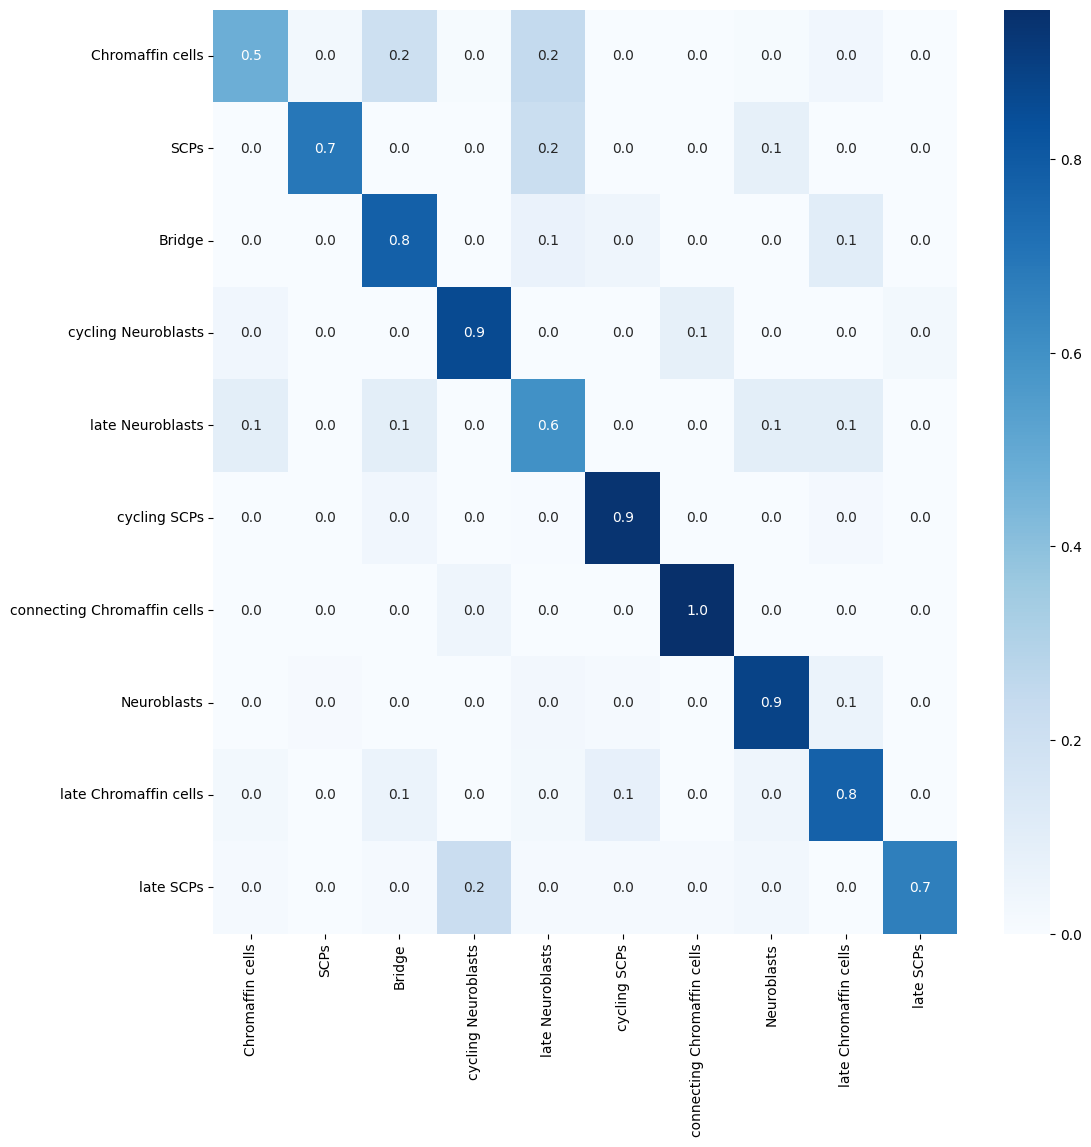

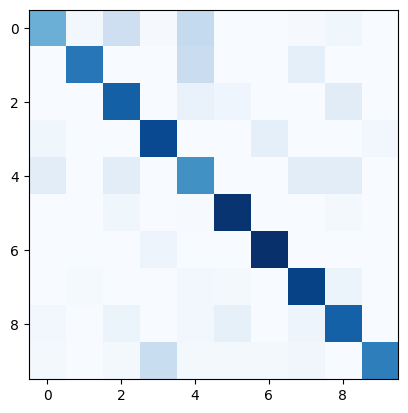

In [9]:
import matplotlib.pyplot as plt

left_out_patients_all = []
test_set_evaluations_all = []
left_out_evaluations_all = []
id2type_all = []
id2type_unseen_all = []    

for _ in range(2):  # Run the evaluation n times with different random splits
    ax, unseen_patients, id2type, id2type_unseen, test_set_eval, left_out_eval, disp = calculate_evaluations(adata)
    left_out_evaluations_all.append(left_out_eval)
    test_set_evaluations_all.append(test_set_eval)
    left_out_patients_all.append(unseen_patients)
    id2type_all.append(id2type)
    id2type_unseen_all.append(id2type_unseen)

    plt.show()
